In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

import os
os.chdir("..")
from Analysis.utils import filter_opto_data, smooth
from ms_opto_stim_protocol import OptoStimProtocol
from Style.style_guide import animal_style

def bootstrap_traces(data, sample_size=None, statistic=np.mean,
                     n_boot=1e3 ,conf_interval=95,):
    if sample_size is None:
        sample_size = data.shape[0]
    bootstrap = []
#     for i in tqdm(range(int(n_boot)),position=0,leave=True):
    for i in range(int(n_boot)):
        bootstrap.append(statistic(data[np.random.choice(np.arange(data.shape[0]),sample_size),:],axis=0))
    bootstrap = np.array(bootstrap)
    return np.mean(bootstrap,axis=0), [np.percentile(bootstrap,(100-conf_interval)/2,axis=0),
                                    np.percentile(bootstrap,conf_interval+(100-conf_interval)/2,axis=0)]

def normalized_mean(data,axis=0):
    return np.mean(data,axis=axis)/np.mean(data)

[2024-06-03 10:25:17,629][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-06-03 10:25:17,708][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


# Individual animal

In [3]:
Decoder = SortedSpikesDecodingV1
animal_list = animal_style.index.values
mua_results = {}

for animal in animal_list:
       if animal in mua_results:
              continue
       
       dataset_key = {'animal':animal,
                     'targeted_phase':90,
                     'track_type':'lineartrack',
                     'min_pulse_length':20}
       dataset = filter_opto_data(dataset_key)
       mua_plot = []

       nwb_file_name = dataset.fetch("nwb_file_name")[0]
       interval_list_name = dataset.fetch("interval_list_name")[0]
       encoding_tag = ""
       causal_tag= ""


       for nwb_file_name, interval_list_name in zip(*dataset.fetch("nwb_file_name","interval_list_name")):
              key = {'nwb_file_name':nwb_file_name,'position_group_name':interval_list_name,
                     'encoding_interval':interval_list_name+encoding_tag,
                     }
              query = ((Decoder() & key) & f"decoding_param_name LIKE '%{causal_tag}'"
                     & "sorted_spikes_group_name NOT LIKE 'manual%'")
              if not query:
                     continue
              key = query.fetch1('KEY')

              opto_key = {'nwb_file_name':nwb_file_name,'interval_list_name':interval_list_name,}
              stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)
              test_interval = np.array((OptoStimProtocol() & opto_key).fetch1("test_intervals"))
              mua_time = np.arange(np.min(test_interval),np.max(test_interval),0.002)
              mua = SortedSpikesGroup().get_firing_rate(key,mua_time, multiunit=True,smoothing_sigma=0.005)


              t_on = stim_time[stim==1]
              ind_on = np.digitize(t_on, mua_time)
              plot_ind = np.arange(-50,50,1)
              mua_plot.extend([mua[ind+plot_ind] for ind in ind_on if (ind+plot_ind[0]>=0) & (ind+plot_ind[-1]<len(mua))])
       
       if len(mua_plot) == 0:
              continue
       mua_results[animal] = np.squeeze(mua_plot)

[2024-06-03 10:25:24,640][WARNING]: Skipped checksum for file with hash: 9d8a5a49-96aa-de26-7e0c-7f0069c6677d, and path: /stelmo/nwb/raw/Winnie20220717_.nwb


datasets: 2


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (27006, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (26639, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (25958, 6) which is not compliant with NWB 2.5 and greater. The second dime

datasets: 2


[10:26:14][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:26:15][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:26:16][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:26:18][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorti

datasets: 2


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWa

datasets: 2
datasets: 2


[10:27:41][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:27:41][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:27:42][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:27:43][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorti

datasets: 2


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWa

datasets: 2


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWa

datasets: 1


/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: SpatialSeries 'series_11': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[10:30:22][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:30:23][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:30:25][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sor

(-60.0, 60.0)

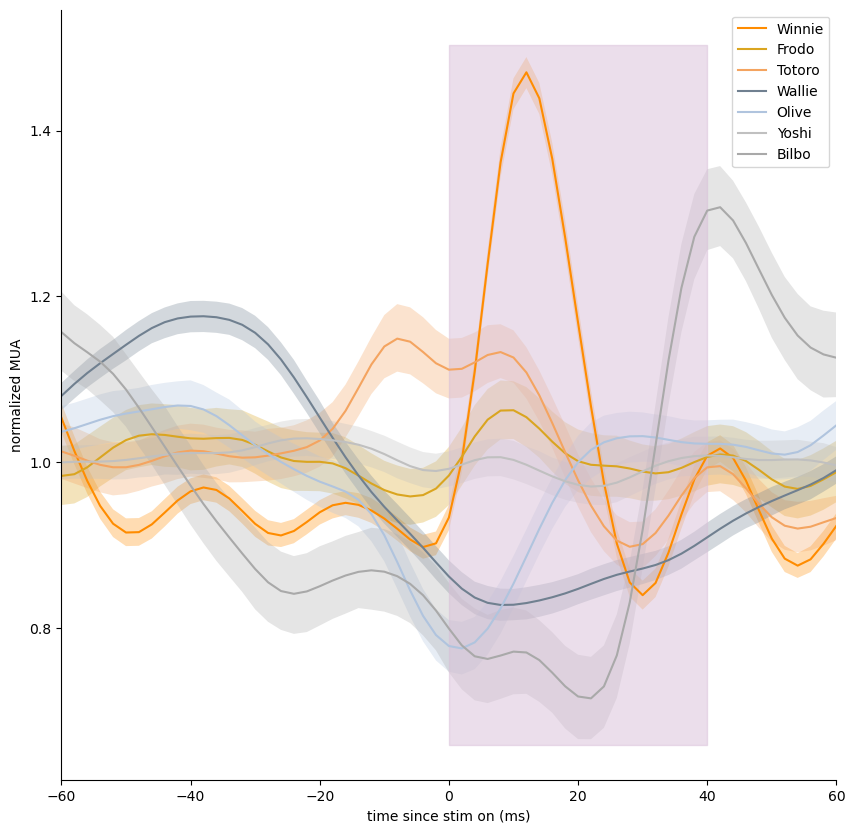

In [8]:


fig = plt.figure(figsize=(10,10))
ax = [fig.gca()]

lo = None
hi = None
for animal in mua_results:
    color = animal_style.loc[animal,'color']
    mua_plot = mua_results[animal]
    plot_ind = np.arange(-50,50,1)

    yy,rng = bootstrap_traces(mua_plot,statistic=normalized_mean,n_boot=1e3)

    if lo is None or lo>rng[0].min():
        lo = rng[0].min()
    if hi is None or hi<rng[1].max():
        hi = rng[1].max()
    
    ax[0].plot(plot_ind*2,yy, color=color,label=animal)
    ax[0].fill_between(plot_ind*2,*rng, facecolor=color, alpha=0.3)

lo = lo*.99
hi = hi*1.01


ax[0].fill_between([0,40],[lo]*2,[hi]*2, color='thistle', alpha=0.5)
ax[0].legend()

for a in ax:
    a.spines[['top', 'right']].set_visible(False)
plt.xlabel('time since stim on (ms)')
ax[0].set_ylabel('normalized MUA')
plt.xlim(-60,60)

In [11]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("./Plots/mua_normalized.svg",format="svg")

# group transfected and control

In [12]:
Decoder = SortedSpikesDecodingV1
animal_list = animal_style.index.values
mua_results = {}

for transfected in [True,False]:
    if animal in mua_results:
            continue
    
    dataset_key = {'targeted_phase':90,
                    'track_type':'lineartrack',
                    'min_pulse_length':20,
                    'transfected':transfected}
    dataset = filter_opto_data(dataset_key)
    mua_plot = []
    encoding_tag = ""
    causal_tag= ""


    for nwb_file_name, interval_list_name in zip(*dataset.fetch("nwb_file_name","interval_list_name")):
            key = {'nwb_file_name':nwb_file_name,'position_group_name':interval_list_name,
                    'encoding_interval':interval_list_name+encoding_tag,
                    }
            query = ((Decoder() & key) & f"decoding_param_name LIKE '%{causal_tag}'"
                    & "sorted_spikes_group_name NOT LIKE 'manual%'")
            if not query:
                    continue
            key = query.fetch1('KEY')

            opto_key = {'nwb_file_name':nwb_file_name,'interval_list_name':interval_list_name,}
            stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)
            test_interval = np.array((OptoStimProtocol() & opto_key).fetch1("test_intervals"))
            mua_time = np.arange(np.min(test_interval),np.max(test_interval),0.002)
            mua = SortedSpikesGroup().get_firing_rate(key,mua_time, multiunit=True,smoothing_sigma=0.005)


            t_on = stim_time[stim==1]
            ind_on = np.digitize(t_on, mua_time)
            plot_ind = np.arange(-50,50,1)
            mua_plot.extend([mua[ind+plot_ind] for ind in ind_on if (ind+plot_ind[0]>=0) & (ind+plot_ind[-1]<len(mua))])
    
    if transfected:
        mua_results["transfected"] = np.squeeze(mua_plot)
    else:
        mua_results["control"] = np.squeeze(mua_plot)

[2024-06-03 10:34:51,233][WARNING]: Skipped checksum for file with hash: 1f5c50a7-0065-fa56-18eb-45182d0fa2f5, and path: /stelmo/nwb/raw/Frodo20230810_.nwb


datasets: 8


[10:34:51][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:34:52][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:34:53][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:34:54][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorti

datasets: 7


[10:36:29][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:36:30][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:36:31][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorting`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[10:36:31][WARNING] Spyglass: Multiple classes found in stack: {'`decoding_sorted_spikes_v1`.`__sorted_spikes_decoding_v1`', '`spikesorting_curation`.`__curated_spike_sorti

(-60.0, 60.0)

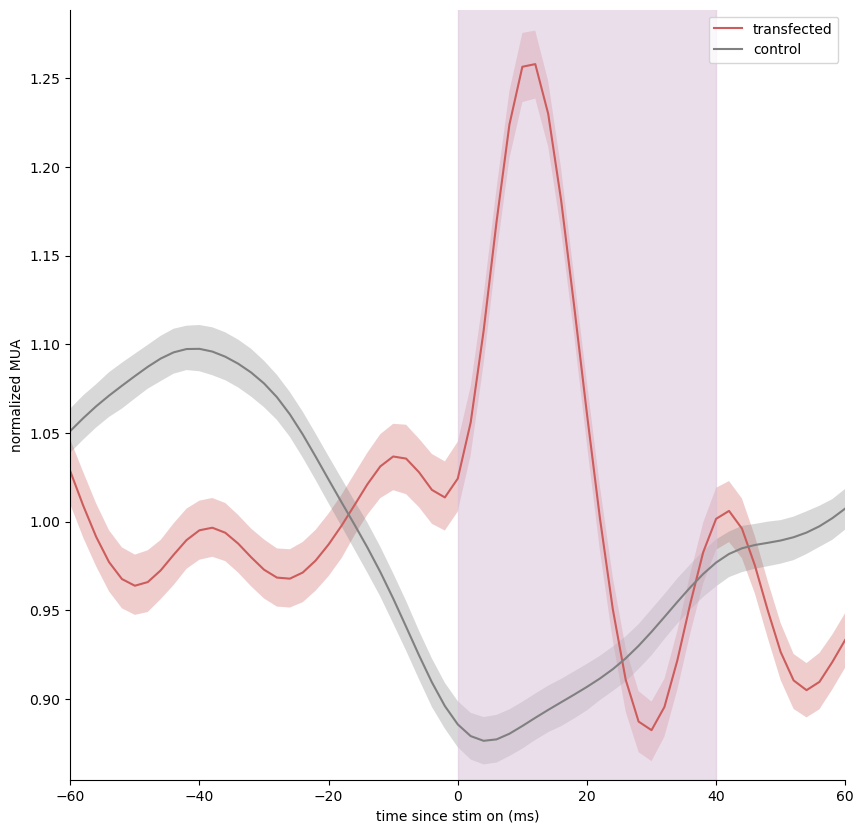

In [14]:
from Style.style_guide import transfection_style

fig = plt.figure(figsize=(10,10))
ax = [fig.gca()]

lo = None
hi = None
for animal in mua_results:
    if animal == "non-transfected":
        color = transfection_style["control"]
    else:
        color = transfection_style[animal]
    mua_plot = mua_results[animal]
    plot_ind = np.arange(-50,50,1)
    # add mua
    # yy = np.squeeze(np.mean(mua_plot,axis=0))/np.mean(mua_plot)
    # rng = np.squeeze(np.std(mua_plot,axis=0))

    yy,rng = bootstrap_traces(mua_plot,statistic=normalized_mean,n_boot=1e3)

    if lo is None or lo>rng[0].min():
        lo = rng[0].min()
    if hi is None or hi<rng[1].max():
        hi = rng[1].max()
    
    ax[0].plot(plot_ind*2,yy, color=color,label=animal)
    ax[0].fill_between(plot_ind*2,*rng, facecolor=color, alpha=0.3)

lo = lo*.99
hi = hi*1.01


ax[0].fill_between([0,40],[lo]*2,[hi]*2, color='thistle', alpha=0.5)
ax[0].legend()

for a in ax:
    a.spines[['top', 'right']].set_visible(False)
plt.xlabel('time since stim on (ms)')
ax[0].set_ylabel('normalized MUA')
ax[0].set_ylim(lo,hi-.001)
plt.xlim(-60,60)

In [16]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("./Plots/mua_normalized_grouped.svg",format="svg")

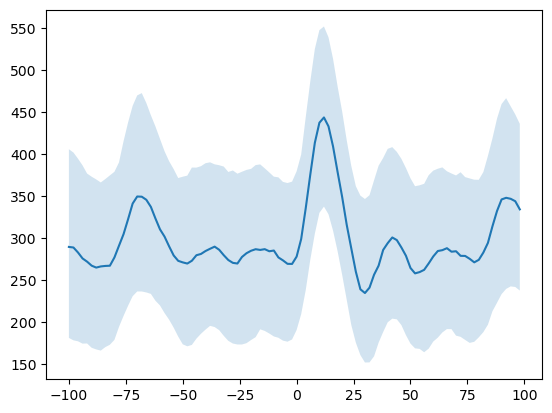

In [32]:
mid = np.median(mua_plot,axis=0)
lo = np.squeeze(np.percentile(mua_plot,25,axis=0))
hi = np.squeeze(np.percentile(mua_plot,75,axis=0))
plt.plot(plot_ind*2,mid)
plt.fill_between(plot_ind*2,lo,hi, alpha=0.2)


In [20]:
lo.shape

(100, 1)